# Memento 1K1K validation

In [25]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import itertools
from pybedtools import BedTool
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sklearn.linear_model as lm

import os
import pickle as pkl
%matplotlib inline
import qvalue

In [26]:
import imp

In [27]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.8-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [133]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)


In [28]:
data_path  = '/data_volume/memento/lupus/'

### Read OneK labels

In [29]:
# Read the OneK result
onek_replication = pd.read_csv(data_path + 'filtered_onek_eqtls.csv')

In [30]:
cts = onek_replication.cg_cov.drop_duplicates().tolist()

### Read full results and compute power

In [35]:
thresh_list = np.linspace(0, 1, 100)

In [56]:
power = []
for pop in ['asian', 'eur']:
    for ct in cts:
        print(pop, ct)
        mem = pd.read_table(data_path + 'full_analysis/memento/100kb/{}_{}.csv'.format(pop, ct), sep=',')
        meq = pd.read_table(data_path + 'full_analysis/mateqtl/outputs/{}_{}_all_hg19.csv'.format(pop, ct), sep='\t')
        ground_truth = onek_replication.query('cg_cov == "{}"'.format(ct))[['gene', 'rsid']]\
            .rename(columns={'rsid':'SNP'})
        mem = mem.merge(ground_truth, on=['gene', 'SNP'])
        meq = meq.merge(ground_truth, on=['gene', 'SNP'])
        for thresh in thresh_list:
            power.append((pop, ct, 'mem', thresh, (mem['p-value'] < thresh).mean()  ))
            power.append((pop, ct, 'meq', thresh, (meq['p-value'] < thresh).mean()  ))
power = pd.DataFrame(power, columns=['pop', 'ct', 'method', 'thresh','power'])

asian B
asian T8
asian T4
asian NK
asian cM
asian ncM
eur B
eur T8
eur T4
eur NK
eur cM
eur ncM


### Read shuffled results and compute FPR

In [63]:
fpr = []
for ct in cts:
    print(ct)
    meq = pd.read_csv(data_path + 'mateqtl_output/{}_filtered_shuffled.out'.format(ct), sep='\t')
    mem = pd.read_csv(data_path + 'memento_1k/{}_shuffled.csv'.format(ct))
    merged = mem.rename(columns={'tx':'SNP'}).merge(meq, on=['SNP', 'gene'])
    
    for thresh in thresh_list:
        fpr.append((ct, 'mem', thresh,mem.query('de_pval < {}'.format(thresh)).shape[0]/mem.shape[0]))
        fpr.append((ct, 'meq', thresh,merged[merged['p-value']<thresh].shape[0]/merged.shape[0]))
fpr = pd.DataFrame(fpr, columns=['ct', 'method', 'thresh','fpr'])   

B
T8
T4
NK
cM
ncM


### Combine power and FPR

In [74]:
roc_curve = power.merge(fpr, on=['ct', 'method', 'thresh']).sort_values(['pop', 'ct', 'method', 'thresh'])
roc_curve = roc_curve.groupby(['pop','method','thresh'])[['power', 'fpr']].mean().reset_index()

In [75]:
roc_curve = roc_curve.groupby(['pop','method','thresh'])[['power', 'fpr']].mean().reset_index()

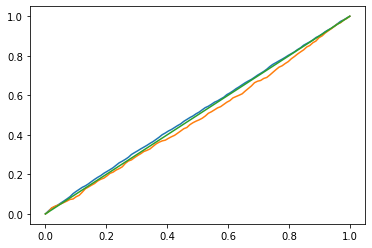

In [87]:
plt.plot(thresh_list, roc_curve.query('pop == "{}" & method == "mem"'.format(pop))['fpr'])
plt.plot(thresh_list, roc_curve.query('pop == "{}" & method == "meq"'.format(pop))['fpr'])
plt.plot([0, 1], [0, 1])

In [126]:
from matplotlib.colors import ListedColormap
cmap = sns.color_palette('Set2', 6)

0.84987426258246
0.8083256181183143


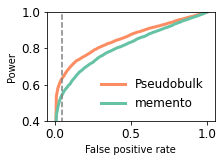

In [141]:
plt.figure(figsize=(3,2))
pop = 'asian'
data = roc_curve.query('pop == "{}" & method == "mem"'.format(pop))
plt.plot(thresh_list, data['power'], color=cmap[1], lw=3)
print(auc(thresh_list, data['power']))
data = roc_curve.query('pop == "{}" & method == "meq"'.format(pop))
plt.plot(thresh_list, data['power'], color=cmap[0], lw=3)
print(auc(thresh_list, data['power']))
plt.plot([0.05, 0.05], [0.3, 1], '--',color='grey')
plt.ylim(0.4, 1)
# plt.xlim(-0.03, 0.9)
plt.legend(['Pseudobulk', 'memento'], frameon=False)
plt.xlabel('False positive rate');
plt.ylabel('Power')

plt.savefig('roc_curve.pdf', bbox_inches='tight')

0.8731550020717053
0.8396530136412799


Text(0, 0.5, 'Power')

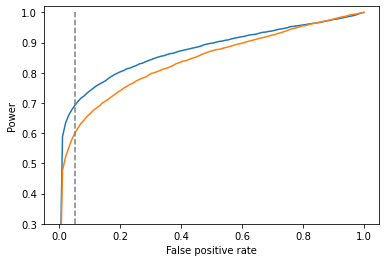

In [105]:
pop = 'eur'
data = roc_curve.query('pop == "{}" & method == "mem"'.format(pop))
plt.plot(thresh_list, data['power'])
print(auc(thresh_list, data['power']))
data = roc_curve.query('pop == "{}" & method == "meq"'.format(pop))
plt.plot(thresh_list, data['power'])
print(auc(thresh_list, data['power']))
plt.plot([0.05, 0.05], [0.3, 1], '--',color='grey')
plt.ylim(0.3, 1.02)



In [9]:
# adata = sc.read(data_path + 'single_cell/{}.h5ad'.format(ct))
# adata = adata[adata.obs.ind_cov.isin(asian_pos.columns)].copy()

In [10]:
# Run for asian population
for ct in cts:
    
    adata = sc.read(data_path + 'single_cell/asian_{}.h5ad'.format(ct))
    adata = adata[adata.obs.ind_cov.isin(asian_pos.columns)].copy()

    adata.obs['capture_rate'] = 0.1
    memento.setup_memento(adata, q_column='capture_rate', trim_percent=0.1, filter_mean_thresh=0.01)
    adata.obs['memento_size_factor'] = 1.0
    memento.create_groups(adata, label_columns=['ind_cov'])

#     cov_df = covariates[['age', 'status','Female'] + [x for x in covariates.columns if '_g' in x or '_e' in x]].loc[[x[3:] for x in adata.uns['memento']['groups']]]
    cov_df = asian_cov.loc[[x[3:] for x in adata.uns['memento']['groups']]]

    donor_df = asian_pos[[x[3:] for x in adata.uns['memento']['groups']]].T
    
    gene_snp_pairs = onek_replication.query('cg_cov == "{}"'.format(ct))
    memento.compute_1d_moments(adata, min_perc_group=.9, gene_list=gene_snp_pairs.gene.drop_duplicates().tolist())

    gene_to_snp = dict(gene_snp_pairs[gene_snp_pairs.gene.isin(adata.var.index)].groupby('gene').rsid.apply(list))
   
    memento.ht_1d_moments(
        adata, 
        covariate=cov_df,
        treatment=donor_df,
        treatment_for_gene=gene_to_snp,
        num_boot=5000, 
        verbose=1,
        num_cpus=93,
        resampling='bootstrap',
        approx=True,
        resample_rep=True)
    
#     adata.write(data_path + 'memento_1k/{}.h5ad'.format(ct))
    memento.get_1d_ht_result(adata).to_csv(data_path + 'memento_1k/asian_{}.csv'.format(ct), index=False)


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=93)]: Using backend LokyBackend with 93 concurrent workers.
[Parallel(n_jobs=93)]: Done  14 tasks      | elapsed:    5.4s
[Parallel(n_jobs=93)]: Done 264 tasks      | elapsed:    8.7s
[Parallel(n_jobs=93)]: Done 474 out of 474 | elapsed:   13.0s finished
[Parallel(n_jobs=93)]: Using backend LokyBackend with 93 concurrent workers.
[Parallel(n_jobs=93)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=93)]: Done 264 tasks      | elapsed:    4.5s
[Parallel(n_jobs=93)]: Done 784 out of 784 | elapsed:   14.0s finished
[Parallel(n_jobs=93)]: Using backend LokyBackend with 93 concurrent workers.
[Parallel(n_jobs=93)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=93)]: Done 264 ta

In [11]:
# Run for eur population
for ct in cts:
    
    adata = sc.read(data_path + 'single_cell/eur_{}.h5ad'.format(ct))
    adata = adata[adata.obs.ind_cov.isin(eur_pos.columns)].copy()

    adata.obs['capture_rate'] = 0.1
    memento.setup_memento(adata, q_column='capture_rate', trim_percent=0.1, filter_mean_thresh=0.01)
    adata.obs['memento_size_factor'] = 1.0
    memento.create_groups(adata, label_columns=['ind_cov'])

#     cov_df = covariates[['age', 'status','Female'] + [x for x in covariates.columns if '_g' in x or '_e' in x]].loc[[x[3:] for x in adata.uns['memento']['groups']]]
    cov_df = eur_cov.loc[[x[3:] for x in adata.uns['memento']['groups']]]

    donor_df = eur_pos[[x[3:] for x in adata.uns['memento']['groups']]].T
    
    gene_snp_pairs = onek_replication.query('cg_cov == "{}"'.format(ct))
    memento.compute_1d_moments(adata, min_perc_group=.9, gene_list=gene_snp_pairs.gene.drop_duplicates().tolist())

    gene_to_snp = dict(gene_snp_pairs[gene_snp_pairs.gene.isin(adata.var.index)].groupby('gene').rsid.apply(list))
   
    memento.ht_1d_moments(
        adata, 
        covariate=cov_df,
        treatment=donor_df,
        treatment_for_gene=gene_to_snp,
        num_boot=5000, 
        verbose=1,
        num_cpus=93,
        resampling='bootstrap',
        approx=True,
        resample_rep=True)
    
#     adata.write(data_path + 'memento_1k/{}.h5ad'.format(ct))
    memento.get_1d_ht_result(adata).to_csv(data_path + 'memento_1k/eur_{}.csv'.format(ct), index=False)


[Parallel(n_jobs=93)]: Using backend LokyBackend with 93 concurrent workers.
[Parallel(n_jobs=93)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=93)]: Done 264 tasks      | elapsed:    3.9s
[Parallel(n_jobs=93)]: Done 499 out of 499 | elapsed:    8.2s finished
[Parallel(n_jobs=93)]: Using backend LokyBackend with 93 concurrent workers.
[Parallel(n_jobs=93)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=93)]: Done 264 tasks      | elapsed:    4.1s
[Parallel(n_jobs=93)]: Done 614 tasks      | elapsed:    8.9s
[Parallel(n_jobs=93)]: Done 854 out of 854 | elapsed:   13.4s finished
[Parallel(n_jobs=93)]: Using backend LokyBackend with 93 concurrent workers.
[Parallel(n_jobs=93)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=93)]: Done 264 tasks      | elapsed:    3.9s
[Parallel(n_jobs=93)]: Done 614 tasks      | elapsed:    8.7s
[Parallel(n_jobs=93)]: Done 1058 out of 1058 | elapsed:   16.9s finished
[Parallel(n_jobs=93)]: Using backend LokyBackend with 93 c

### Filter the pseudobulks by these genes

In [21]:
for ct in cts:
    
    memento_result = pd.read_csv(data_path + 'memento_1k/asian_{}.csv'.format(ct))
    pseudobulk = pd.read_csv(data_path + 'pseudobulk/asian_{}.csv'.format(ct), index_col=0, sep='\t')
    pseudobulk = pseudobulk[memento_result['gene'].drop_duplicates().tolist()]
    pseudobulk.T.to_csv(data_path + 'pseudobulk/asian_{}_filtered.csv'.format(ct), sep='\t')
    

In [22]:
for ct in cts:
    
    memento_result = pd.read_csv(data_path + 'memento_1k/eur_{}.csv'.format(ct))
    pseudobulk = pd.read_csv(data_path + 'pseudobulk/eur_{}.csv'.format(ct), index_col=0, sep='\t')
    pseudobulk = pseudobulk[memento_result['gene'].drop_duplicates().tolist()]
    pseudobulk.T.to_csv(data_path + 'pseudobulk/eur_{}_filtered.csv'.format(ct), sep='\t')
    

### Power calculation

In [8]:
# Power - Asian
for ct in cts:
    print(ct)
    meq = pd.read_csv(data_path + 'mateqtl_output/asian_{}_filtered.out'.format(ct), sep='\t')
    mem = pd.read_csv(data_path + 'memento_1k/asian_{}.csv'.format(ct))
    merged = mem.rename(columns={'tx':'SNP'}).merge(meq, on=['SNP', 'gene'])
    print(mem.shape[0], merged.shape[0])
    print('memento', mem.query('de_pval < 0.05').shape[0]/mem.shape[0], mem.query('de_pval < 0.05').shape[0])
    print('mat eqtl',merged[merged['p-value']<0.05].shape[0]/mem.shape[0], merged[merged['p-value']<0.05].shape[0])


B
694 693
memento 0.515850144092219 358
mat eqtl 0.4034582132564842 280
T8
1274 1274
memento 0.49843014128728413 635
mat eqtl 0.4434850863422292 565
T4
1224 1224
memento 0.4616013071895425 565
mat eqtl 0.40441176470588236 495
NK
675 510
memento 0.40444444444444444 273
mat eqtl 0.24592592592592594 166
cM
243 243
memento 0.6995884773662552 170
mat eqtl 0.6666666666666666 162
ncM
240 125
memento 0.5875 141
mat eqtl 0.32916666666666666 79


In [ ]:
# Power - European
for ct in cts:
    print(ct)
    meq = pd.read_csv(data_path + 'mateqtl_output/eur_{}_filtered.out'.format(ct), sep='\t')
    mem = pd.read_csv(data_path + 'memento_1k/eur_{}.csv'.format(ct))
    merged = mem.rename(columns={'tx':'SNP'}).merge(meq, on=['SNP', 'gene'])
    print(mem.shape[0], merged.shape[0])
    print('memento', mem.query('de_pval < 0.05').shape[0]/mem.shape[0], mem.query('de_pval < 0.05').shape[0])
    print('mat eqtl',merged[merged['p-value']<0.05].shape[0]/mem.shape[0], merged[merged['p-value']<0.05].shape[0])


In [9]:
# False positive rate
for ct in cts:
    print(ct)
    meq = pd.read_csv(data_path + 'mateqtl_output/{}_filtered_shuffled.out'.format(ct), sep='\t')
    mem = pd.read_csv(data_path + 'memento_1k/{}_shuffled.csv'.format(ct))
    merged = mem.rename(columns={'tx':'SNP'}).merge(meq, on=['SNP', 'gene'])
    print('memento', mem.query('de_pval < 0.05').shape[0]/mem.shape[0])
    print('mat eqtl',merged[merged['p-value']<0.05].shape[0]/merged.shape[0])

B
memento 0.06399235912129896
mat eqtl 0.04180064308681672
T8
memento 0.0583596214511041
mat eqtl 0.050359712230215826
T4
memento 0.05263157894736842
mat eqtl 0.049145299145299144
NK
memento 0.0420017873100983
mat eqtl 0.059782608695652176
cM
memento 0.03550295857988166
mat eqtl 0.05673758865248227
ncM
memento 0.07580174927113703
mat eqtl 0.046511627906976744


### AUC curve

In [10]:
thresh = 0.05

In [11]:
thresh_list = np.linspace(0, 1, 100)

In [13]:
merged.shape

(125, 12)

In [15]:
mem.shape

(240, 8)

B
T8
T4
NK
cM
ncM


Text(0.5, 1.0, 'ncM')

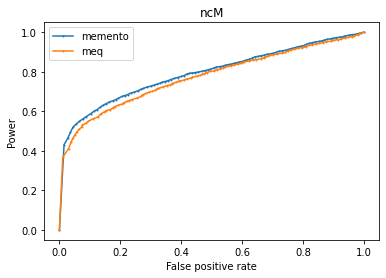

In [20]:
fpr_mem_all = []
power_mem_all = []
fpr_meq_all = []
power_meq_all = []

for ct in cts:
    print(ct)
    meq = pd.read_csv(data_path + 'mateqtl_output/asian_{}_filtered.out'.format(ct), sep='\t')
    mem = pd.read_csv(data_path + 'memento_1k/asian_{}.csv'.format(ct))
    
    meq_shuffled = pd.read_csv(data_path + 'mateqtl_output/{}_filtered_shuffled.out'.format(ct), sep='\t')
    mem_shuffled = pd.read_csv(data_path + 'memento_1k/{}_shuffled.csv'.format(ct))
    
    merged = mem.rename(columns={'tx':'SNP'}).merge(meq, on=['SNP', 'gene'])
    merged_shuffled = mem_shuffled.rename(columns={'tx':'SNP'}).merge(meq_shuffled, on=['SNP', 'gene'])
    
    power_mem_list, power_meq_list, fpr_mem_list, fpr_meq_list = [], [], [], []
    
    for thresh in thresh_list:
    
        power_mem = merged.query('de_pval < {}'.format(thresh)).shape[0]/merged.shape[0]
        power_meq = merged[merged['p-value']<thresh].shape[0]/merged.shape[0]

        fpr_mem =  mem_shuffled.query('de_pval < {}'.format(thresh)).shape[0]/mem_shuffled.shape[0]
        fpr_meq = merged_shuffled[merged_shuffled['p-value']<thresh].shape[0]/merged_shuffled.shape[0]
        
        power_mem_list.append(power_mem)
        power_meq_list.append(power_meq)
        fpr_mem_list.append(fpr_mem)
        fpr_meq_list.append(fpr_meq)
    
    fpr_mem_list = np.array(fpr_mem_list)
    power_mem_list = np.array(power_mem_list)
    fpr_meq_list = np.array(fpr_meq_list)
    power_meq_list = np.array(power_meq_list)
    
    fpr_mem_all.append(np.array(fpr_mem_list))
    power_mem_all.append(np.array(power_mem_list))
    fpr_meq_all.append(np.array(fpr_meq_list))
    power_meq_all.append(np.array(power_meq_list))
    
plt.figure()
plt.plot(np.vstack(fpr_mem_all).mean(axis=0), np.vstack(power_mem_all).mean(axis=0), 'o-', markersize=1)
plt.plot(np.vstack(fpr_meq_all).mean(axis=0), np.vstack(power_meq_all).mean(axis=0), 'o-', markersize=1)
plt.legend(['memento', 'meq'])

plt.xlabel('False positive rate');
plt.ylabel('Power')
plt.title(ct)


In [22]:
from sklearn.metrics import auc

In [23]:
auc(np.vstack(fpr_mem_all).mean(axis=0), np.vstack(power_mem_all).mean(axis=0))

0.7920551114998023

In [24]:
auc(np.vstack(fpr_meq_all).mean(axis=0), np.vstack(power_meq_all).mean(axis=0))

0.7726148281706495

B
T8
T4
NK
cM
ncM


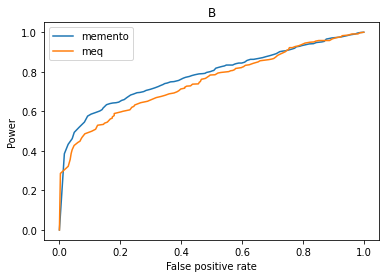

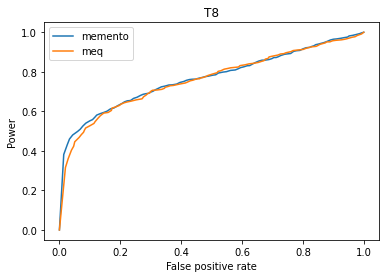

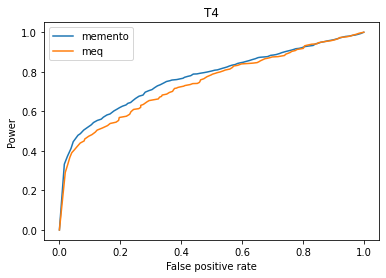

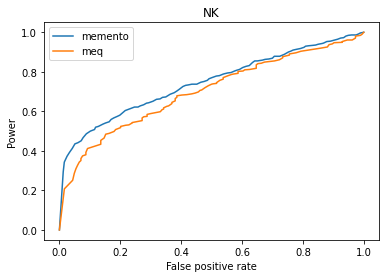

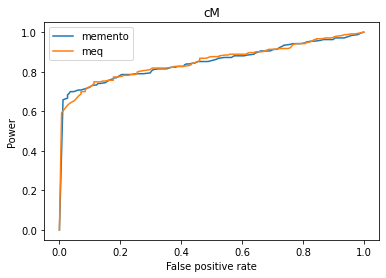

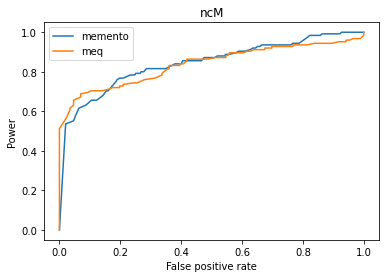

In [16]:
for ct in cts:
    print(ct)
    meq = pd.read_csv(data_path + 'mateqtl_output/asian_{}_filtered.out'.format(ct), sep='\t')
    mem = pd.read_csv(data_path + 'memento_1k/asian_{}.csv'.format(ct))
    
    meq_shuffled = pd.read_csv(data_path + 'mateqtl_output/{}_filtered_shuffled.out'.format(ct), sep='\t')
    mem_shuffled = pd.read_csv(data_path + 'memento_1k/{}_shuffled.csv'.format(ct))
    
    merged = mem.rename(columns={'tx':'SNP'}).merge(meq, on=['SNP', 'gene'])
    merged_shuffled = mem_shuffled.rename(columns={'tx':'SNP'}).merge(meq_shuffled, on=['SNP', 'gene'])
    
    power_mem_list, power_meq_list, fpr_mem_list, fpr_meq_list = [], [], [], []
    
    for thresh in thresh_list:
    
        power_mem = merged.query('de_pval < {}'.format(thresh)).shape[0]/merged.shape[0]
        power_meq = merged[merged['p-value']<thresh].shape[0]/merged.shape[0]

        fpr_mem =  mem_shuffled.query('de_pval < {}'.format(thresh)).shape[0]/mem_shuffled.shape[0]
        fpr_meq = merged_shuffled[merged_shuffled['p-value']<thresh].shape[0]/merged_shuffled.shape[0]
        
        power_mem_list.append(power_mem)
        power_meq_list.append(power_meq)
        fpr_mem_list.append(fpr_mem)
        fpr_meq_list.append(fpr_meq)
    plt.figure()
    plt.plot(fpr_mem_list, power_mem_list, '-', markersize=1)
    plt.plot(fpr_meq_list, power_meq_list, '-', markersize=1)
    plt.legend(['memento', 'meq'])

    plt.xlabel('False positive rate');
    plt.ylabel('Power')
    plt.title(ct)


In [ ]:
for ct in cts:
    print(ct)
    meq = pd.read_csv(data_path + 'mateqtl_output/asian_{}_filtered.out'.format(ct), sep='\t')
    mem = pd.read_csv(data_path + 'memento_1k/asian_{}.csv'.format(ct))
    
    meq_shuffled = pd.read_csv(data_path + 'mateqtl_output/{}_filtered_shuffled.out'.format(ct), sep='\t')
    mem_shuffled = pd.read_csv(data_path + 'memento_1k/{}_shuffled.csv'.format(ct))
    
    merged = mem.rename(columns={'tx':'SNP'}).merge(meq, on=['SNP', 'gene'])
    merged_shuffled = mem_shuffled.rename(columns={'tx':'SNP'}).merge(meq_shuffled, on=['SNP', 'gene'])
    
    power_mem_list, power_meq_list, fpr_mem_list, fpr_meq_list = [], [], [], []
    
    for thresh in thresh_list:
    
        power_mem = mem.query('de_pval < {}'.format(thresh)).shape[0]/mem.shape[0]
        power_meq = merged[merged['p-value']<thresh].shape[0]/mem.shape[0]

        fpr_mem =  mem_shuffled.query('de_pval < {}'.format(thresh)).shape[0]/mem_shuffled.shape[0]
        fpr_meq = merged_shuffled[merged_shuffled['p-value']<thresh].shape[0]/merged_shuffled.shape[0]
        
        power_mem_list.append(power_mem)
        power_meq_list.append(power_meq)
        fpr_mem_list.append(fpr_mem)
        fpr_meq_list.append(fpr_meq)
    plt.figure()
    plt.plot(fpr_mem_list, power_mem_list, '-', markersize=1)
    plt.plot(fpr_meq_list, power_meq_list, '-', markersize=1)
    plt.legend(['memento', 'mat eqtl'])

    plt.xlabel('False positive rate');
    plt.ylabel('Power')
    plt.title(ct)

### Characteristics of non-mateqtl memento eQTLs

In [249]:
ct = 'cM'
meq = pd.read_csv(data_path + 'mateqtl_output/asian_{}_filtered.out'.format(ct), sep='\t')
mem = pd.read_csv(data_path + 'memento_1k/asian_{}.csv'.format(ct))
merged = mem.rename(columns={'tx':'SNP'}).merge(meq, on=['SNP', 'gene'])

In [250]:
merged.shape

(243, 12)

In [251]:
mem_only_genes = merged[merged['p-value'] > 0.1].query('de_pval < 0.05').gene.tolist()
both_genes = merged[merged['p-value'] < 0.05].query('de_pval < 0.05').gene.tolist()

In [252]:
len(both_genes)

161

In [253]:
len(mem_only_genes)

5

In [ ]:
adata = sc.read(data_path + 'single_cell/{}_{}.h5ad'.format('asian', ct))
adata.obs['capture_rate'] = 0.1
memento.setup_memento(adata, q_column='capture_rate', trim_percent=0.1, filter_mean_thresh=0.01)
memento.create_groups(adata, label_columns=['ind_cov'])
memento.compute_1d_moments(adata, min_perc_group=.9)

In [255]:
m, v = memento.get_1d_moments(adata, groupby='ind_cov')
m = m.set_index('gene')
v = v.set_index('gene')

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.8-py3.8.egg/memento/main.py:572: RuntimeWarning: invalid value encountered in true_divide
  groupby_var[key] /= groupby_var_count[key]


In [256]:
v = np.log(np.exp(v)-1)
m = np.log(np.exp(m)-1)

In [257]:
variance_of_means = pd.DataFrame(m.var(axis=1), columns=['v_of_m'])
mean_of_variances = pd.DataFrame(v.mean(axis=1), columns=['m_of_v'])

In [258]:
metrics = variance_of_means.join(mean_of_variances)

In [259]:
metrics['both'] = metrics.index.isin(both_genes)
metrics['mem_only'] = metrics.index.isin(mem_only_genes)
metrics['log_v_of_m'] = metrics['v_of_m']
metrics['log_m_of_v'] = metrics['m_of_v']

In [260]:
metrics = metrics.query('both | mem_only')

In [261]:
metrics

,v_of_m,m_of_v,both,mem_only,log_v_of_m,log_m_of_v
gene,,,,,,
CDA,0.118196,-4.957962,True,False,0.118196,-4.957962
CDC42,0.038019,-2.611126,True,False,0.038019,-2.611126
SH3BGRL3,0.069197,-1.710132,True,False,0.069197,-1.710132
CD52,0.216378,0.093693,True,False,0.216378,0.093693
THEMIS2,0.170909,-5.325895,True,False,0.170909,-5.325895
...,...,...,...,...,...,...
HMGN1,0.041578,-5.340847,True,False,0.041578,-5.340847
ITGB2,0.291250,-3.210096,True,False,0.291250,-3.210096
ITGB2-AS1,NaN,-4.311694,True,False,NaN,-4.311694


MannwhitneyuResult(statistic=306.0, pvalue=0.18220428586583298)


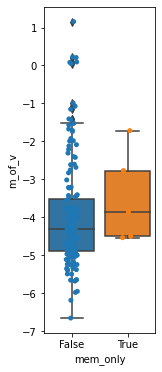

In [264]:
plt.figure(figsize=(2,6))
sns.boxplot(x='mem_only', y='m_of_v', data=metrics)
sns.stripplot(x='mem_only', y='m_of_v', data=metrics)

print(stats.mannwhitneyu(metrics.query('both').m_of_v, metrics.query('mem_only').m_of_v))

MannwhitneyuResult(statistic=372.0, pvalue=0.38842114467635874)


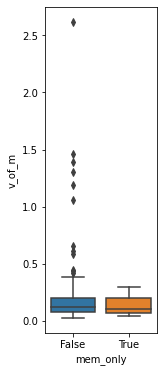

In [263]:
plt.figure(figsize=(2,6))
sns.boxplot(x='mem_only', y='v_of_m', data=metrics)
print(stats.mannwhitneyu(metrics.query('both').v_of_m, metrics.query('mem_only').v_of_m))

In [40]:
metrics

,v_of_m,m_of_v,both,mem_only
gene,,,,
NOC2L,0.000732,-0.008531,False,False
ISG15,0.083771,0.223222,False,False
TNFRSF18,0.004655,0.010949,False,True
SDF4,0.003402,-0.010439,False,False
UBE2J2,0.000967,-0.009570,False,False
...,...,...,...,...
MT-ND4,0.051399,0.730108,False,False
MT-ND5,0.041073,0.176611,False,False
MT-ND6,0.001093,-0.004732,False,False


---------------

In [170]:
covariates.head(5)

,age,Female,batch_cov,status,PC1_e,PC2_e,PC3_e,PC4_e,PC5_e,PC6_e,...,PC8_e,PC9_e,PC10_e,PC1_g,PC2_g,PC3_g,PC4_g,PC5_g,PC6_g,PC7_g
HC-519,21.0,0.0,13.0,1.0,8.582570,-22.828452,17.259928,-5.124023,0.542451,-0.780524,...,-0.425329,7.169390,5.309465,0.0343,-0.0456,0.0413,-0.0635,0.1212,-0.0581,0.0352
1240_1240,23.0,0.0,3.0,0.0,-8.648941,13.411016,5.855519,7.568020,-8.009542,-0.186709,...,2.021136,0.919464,0.047876,-0.0049,0.2181,-0.0730,-0.0005,-0.1076,0.0217,-0.0766
HC-022,74.0,0.0,14.0,1.0,2.728118,-13.795299,1.074720,7.365269,10.467058,-6.088037,...,1.454213,-5.778323,-6.239999,0.0508,0.0020,0.0465,0.1017,-0.1011,0.1246,-0.0559
1771_1771,49.0,0.0,7.0,0.0,-7.359370,10.981154,-0.085993,-23.435739,-0.616778,4.374860,...,-2.862667,9.843410,2.890764,-0.4201,-0.0699,0.0289,0.0594,0.0049,0.0146,0.0126
1472_1472,45.0,0.0,9.0,0.0,-10.204806,12.005469,-18.111741,-6.703906,-3.399169,3.591684,...,-3.815207,5.573024,-1.693832,-0.2214,0.0946,-0.0603,0.0916,-0.0429,-0.0987,0.0742


In [26]:
adata = sc.read(data_path + 'single_cell/{}.h5ad'.format(ct))
expr_df = pd.DataFrame()
expr_df['expr'] = adata[:, 'HLA-DQA1'].X.todense().A1
expr_df['ind_cov'] = adata.obs['ind_cov'].values
expr_df = expr_df.merge(pos.T.reset_index().rename(columns={'index':'ind_cov'})[['ind_cov', '6:32606756']], on='ind_cov')
expr_df = expr_df.merge(covariates.reset_index().rename(columns={'index':'ind_cov'}), on='ind_cov')
ind_list = expr_df['ind_cov'].drop_duplicates().tolist()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [27]:
expr_dict = {ind:expr_df.query('ind_cov == "{}"'.format(ind)).expr.values for ind in ind_list}
geno_dict= {ind:expr_df.query('ind_cov == "{}"'.format(ind))['6:32606756'].mean() for ind in ind_list}

In [28]:
num_rep = len(ind_list)

In [29]:
b_coefs = np.zeros(5000)
for boot_itr in range(5000):
    
    means = np.zeros(num_rep)
    genos = np.zeros(num_rep)
    boot_inds = np.random.choice(ind_list, num_rep)
    for i, ind in enumerate(boot_inds):
        means[i] = np.log(np.random.choice(expr_dict[ind], size=expr_dict[ind].shape[0]).mean()+1)
        genos[i] = geno_dict[ind]
    coef = lm.LinearRegression().fit(np.hstack([genos.reshape(-1,1), covariates.loc[boot_inds, :]]), means.reshape(-1,1)).coef_[0][0]
    b_coefs[boot_itr] = coef
        
        

In [30]:
stats.norm.sf(0, loc=b_coefs.mean(), scale=b_coefs.std())

0.009343063956403932

In [31]:
stats.norm.sf(0, loc=b_coefs.mean(), scale=b_coefs.std())

0.009343063956403932

<AxesSubplot:ylabel='Density'>

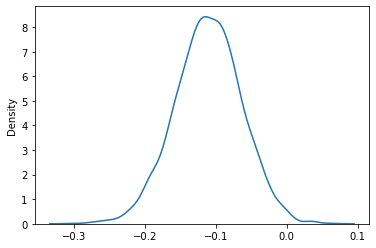

In [32]:
sns.kdeplot(b_coefs)

(array([1.1769e+05, 3.5380e+03, 1.0990e+03, 4.4400e+02, 1.8700e+02,
        1.2400e+02, 3.5000e+01, 1.9000e+01, 1.3000e+01, 4.0000e+00]),
 array([ 0. ,  2.2,  4.4,  6.6,  8.8, 11. , 13.2, 15.4, 17.6, 19.8, 22. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

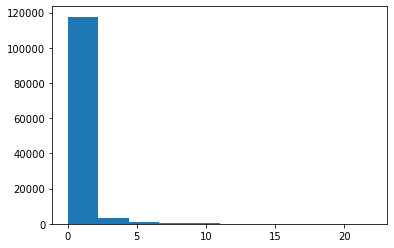

In [34]:
plt.hist(expr_df['expr'])

In [35]:
merged[(merged['de_pval'] > 0.05) & (merged['p-value'] < 0.05)]

,gene,SNP,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,beta,t-stat,p-value,FDR
26,NAGK,2:71297982,-0.021954,0.014456,0.1312,-0.058271,0.090391,0.5094,-0.040998,-4.004192,0.000147,0.494679
28,DBI,2:120122538,-0.035541,0.018912,0.0598,-0.071333,0.101440,0.4754,-0.047208,-2.707891,0.008405,0.999747
50,LY86,6:6580752,0.006995,0.011800,0.5412,0.011583,0.061773,0.8434,0.031648,2.098055,0.039314,0.999747
51,RNF144B,6:18399394,-0.028675,0.015293,0.0556,-0.163962,0.120814,0.1756,-0.029998,-3.587793,0.000596,0.774752
61,HLA-B,6:31236467,0.072618,0.043975,0.0954,0.122051,0.077401,0.1136,0.105643,2.396146,0.019096,0.999747
68,HLA-DQA1,6:32606756,-0.036989,0.029423,0.2056,-0.325402,0.157475,0.0398,-0.094538,-2.085104,0.040509,0.999747
75,DEF6,6:35282463,0.001923,0.002905,0.5052,0.057247,0.100141,0.5718,0.010933,3.392208,0.001116,0.881418
76,RPL10A,6:35436925,-0.042162,0.033861,0.2150,0.066044,0.089817,0.4628,-0.112138,-3.431682,0.000985,0.869185
81,MRPL14,6:44105978,-0.007528,0.007106,0.2892,0.004171,0.123110,0.9716,-0.025175,-4.674135,0.000013,0.104600
139,AP003774.6,11:64158950,-0.003973,0.002667,0.1410,-0.156414,0.124523,0.2078,-0.009340,-3.283494,0.001567,0.916465


In [77]:
ct = 'cM'

In [81]:
meq = pd.read_csv(data_path + 'mateqtl_output/{}_filtered_old.out'.format(ct), sep='\t')
mem = pd.read_csv(data_path + 'memento_1k/{}.csv'.format(ct))

In [82]:
mem.shape

(338, 8)

In [90]:
merged = mem.rename(columns={'tx':'SNP'}).merge(meq[meq['p-value']<0.05], on=['SNP', 'gene'])

In [84]:
merged.shape

(235, 12)

In [87]:
mem.query('de_pval < 0.05').shape[0]/mem.shape[0]

0.5414201183431953

In [93]:
merged.shape[0]/mem.shape[0]

0.6686390532544378

In [105]:
pb1 = pd.read_csv(data_path + 'pseudobulk/{}_filtered.csv'.format(ct), sep='\t', index_col=0).T

In [110]:
pb2 = pd.read_csv(data_path + 'mateqtl_input/cm_cg.expr', sep='\t', index_col=0).T

In [113]:
common_col = list(set(pb1.columns) & set(pb2.columns))

In [114]:
pb1 = pb1[common_col]
pb2 = pb2[common_col]

In [115]:
pb1.head(2)

,MANBA,CHMP4B,GCNT2,TULP4,NUBP2,ELP5,PRMT2,RP11-290F20.3,SUSD3,ZBTB22,...,RPP21,TMEM176A,CST3,ABRACL,CSNK2B,HLA-DRB1,EREG,KDELR2,MRPL14,CRISPLD2
HC-519,0.038563,0.118353,0.001708,0.007663,0.029476,0.009358,0.062935,0.103050,0.009358,0.006814,...,0.021142,0.015268,1.163957,0.123654,0.133425,0.486955,0.159994,0.078068,0.066140,0.038563
1791_1791,0.097786,0.271953,0.016069,0.012174,0.081895,0.024587,0.151495,0.240768,0.028050,0.011393,...,0.036847,0.081895,2.125437,0.254646,0.277356,1.093460,0.138163,0.179619,0.132988,0.108477


In [116]:
pb2.head(2)

Unnamed: 0,MANBA,CHMP4B,GCNT2,TULP4,NUBP2,ELP5,PRMT2,RP11-290F20.3,SUSD3,ZBTB22,...,RPP21,TMEM176A,CST3,ABRACL,CSNK2B,HLA-DRB1,EREG,KDELR2,MRPL14,CRISPLD2
HC-519,5.414605,7.057960,1.672425,3.242791,5.035064,3.493156,6.120243,6.849347,3.493156,3.099173,...,4.573959,4.132487,11.175467,7.124389,7.240184,9.365807,7.519456,6.436379,6.192798,5.414605
1240_1240,5.548255,6.937241,3.156325,3.240748,5.036711,3.536299,6.104814,6.385398,3.890027,2.699946,...,3.664090,6.116033,11.822846,7.426109,7.569707,10.591394,7.821756,6.149176,6.357310,4.630257
